In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision


In [ ]:
import torch

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.CenterCrop((64,64))
  ])

def apply_transform(example):
  image = example["image"]
  image = image[:1,:,:]
  image = image.type(torch.float)
  example["image"] = transform(image)
  return example
  return example

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset



train = load_dataset("maurice-fp/stanford-dogs", split="train")
train = train.with_format("torch")
train = train.shuffle(seed=42)
train = train.select(range(1000))

batch_size = 16
train = train.map(apply_transform)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(train_loader.batch_size)

16


torch.Size([1, 64, 64])


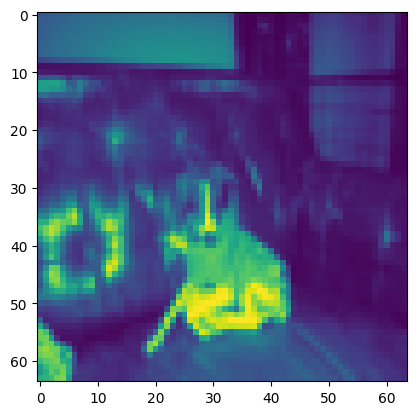

In [ ]:
iter_train = iter(train_loader)

batch = next(iter_train)

image, label = batch["image"][0], batch["label"][0]



print(image.shape)

np_img = image.numpy()

np_img = (np_img-np.min(np_img))/(np.max(np_img)-np.min(np_img)) # Normalizes range to [0..1]
# print(classes[label])
np_img = np_img.transpose(1,2,0)
plt.imshow(np_img)




In [ ]:
latent_dim = 128

import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
  #goal: try and convert the image so that it outputs in the size of a [1,64,64] image
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(in_features = latent_dim, out_features = 8*16*16),
      nn.ReLU(),
      nn.BatchNorm1d(8*16*16),

      nn.Unflatten(dim = 1, unflattened_size = (8,16,16)),

      # 1st Block
      nn.ConvTranspose2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2),
      nn.ReLU(),
      nn.BatchNorm2d(16),

      # 2nd Block
      nn.ConvTranspose2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 2),
      nn.ReLU(),
      nn.BatchNorm2d(32),

      # 3rd Block
      nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2),
      nn.ReLU(),
      nn.BatchNorm2d(64),

      # 4th Block
      nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride = 2, padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(1)



    )
  def forward (self, x):
    img = torch.tanh(self.model(x))



    return img


In [ ]:
G = Generator().to('cpu')


torch.Size([16, 1, 64, 64])


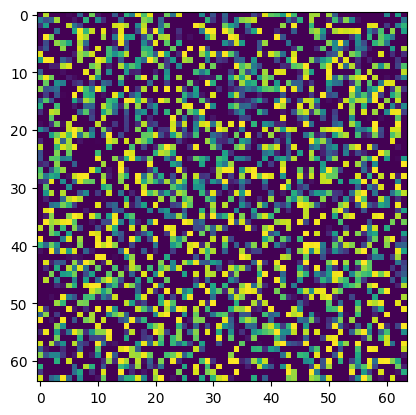

In [ ]:
z = torch.randn(16,latent_dim)
fake = G(z)

print(fake.shape)


fake_img = fake[0].detach().numpy()

fake_img = fake_img.transpose(1,2,0)
plt.imshow(fake_img)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 2, stride = 2),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride = 2),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(in_features = 16384, out_features = 500),
      nn.ReLU(),
      nn.Dropout(p=0.3),

      nn.Linear(in_features = 500, out_features = 1),
      nn.Sigmoid()


    )


  def forward(self, x):
    x = self.model(x)

    return x


In [ ]:
D = Discriminator().to('cpu')



print(D(fake).shape)




fake_probs = torch.argmax(D(fake))
print(D(fake)[fake_probs])
print(fake_probs)


for batch in train_loader:

  images, labels = batch["image"], batch["label"]
  print(f'inputs shape: {images.shape}')
  print(f'labels shape: {labels.shape}')
  print(f'after network: {D(images).shape}')

  print()
  print()

  real_probs = torch.argmax(D(images))
  print(D(images)[real_probs])
  print(real_probs)

  real_labels = torch.full_like(D(images), 0.9)
  print(real_labels)

  break

torch.Size([16, 1])
tensor([0.5161], grad_fn=<SelectBackward0>)
tensor(0)
inputs shape: torch.Size([16, 1, 64, 64])
labels shape: torch.Size([16])
after network: torch.Size([16, 1])


tensor([0.9696], grad_fn=<SelectBackward0>)
tensor(11)
tensor([[0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000],
        [0.9000]])


In [ ]:
num_params = 0

# Discriminator Parameters
for x in D.parameters():
  num_params += len(torch.flatten(x))

print(f'Discriminator parameters: {num_params:,}')

for x in G.parameters():
  num_params += len(torch.flatten(x))

print(f'Generator parameters: {num_params:,}')




Discriminator parameters: 8,201,417
Generator parameters: 8,481,820


In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)
G_optimizer = optim.Adam(G.parameters(), lr=0.00015)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(len(train_loader))

63


In [ ]:
epochs = 25

for epoch in range(epochs):
  print(f'Epoch {epoch+1}')

  G.train(True)
  D.train(True)
  DRunning_loss = 0.0
  GRunning_loss = 0.0

  for index, batch in enumerate(train_loader):
    real_img = batch["image"].to(device)


    ### train discriminator ###
    D_optimizer.zero_grad()



    # fake inputs
    fake_img = torch.randn(16,latent_dim, device = device)
    fake_input = G(fake_img)
    disc_fake = D(fake_input)

    fake_labels = torch.full_like(disc_fake, 0.05)
    dloss_fake = criterion(disc_fake, fake_labels) # 0 refers to fake
    dloss_fake.backward()


    # real inputs
    real_input = D(real_img)

    real_labels = torch.full_like(real_input, 0.95)
    dloss_real = criterion(real_input, real_labels)
    dloss_real.backward()


    # computer both losses
    Dtotal_err = dloss_real + dloss_fake
    DRunning_loss += Dtotal_err
    # Update D
    D_optimizer.step()

    for i in range(2):
      ### train generator ###
      G_optimizer.zero_grad()
      fake_img = torch.randn(4, latent_dim, device=device)
      fake_input = G(fake_img)

      output = D(fake_input)
      real_labels = torch.full_like(output, 0.95)
      G_err = criterion(output, real_labels)
      G_err.backward()

      GRunning_loss += G_err

      #Update G
      G_optimizer.step()



    if (index % 4 == 3):
      print(f'Batch: {index+1}   D_Loss: {DRunning_loss/4:.3f}   G_Loss: {GRunning_loss/8:.3f}')
      DRunning_loss = 0.0
      GRunning_loss = 0.0

with (open('G.pt', 'wb')) as f:
  torch.save(G.state_dict(), f)

with (open('D.pt', 'wb')) as f:
  torch.save(D.state_dict(), f)

print('Finished Training')


Epoch 1
Batch: 4   D_Loss: 4.738   G_Loss: 0.601
Batch: 8   D_Loss: 5.758   G_Loss: 0.685
Batch: 12   D_Loss: 5.603   G_Loss: 0.875
Batch: 16   D_Loss: 5.456   G_Loss: 1.122
Batch: 20   D_Loss: 5.009   G_Loss: 1.399
Batch: 24   D_Loss: 4.103   G_Loss: 1.434
Batch: 28   D_Loss: 5.406   G_Loss: 1.099
Batch: 32   D_Loss: 5.508   G_Loss: 0.913
Batch: 36   D_Loss: 5.547   G_Loss: 0.880
Batch: 40   D_Loss: 5.512   G_Loss: 0.964
Batch: 44   D_Loss: 5.433   G_Loss: 1.138
Batch: 48   D_Loss: 5.353   G_Loss: 1.375
Batch: 52   D_Loss: 5.295   G_Loss: 1.601
Batch: 56   D_Loss: 5.260   G_Loss: 1.799
Batch: 60   D_Loss: 5.238   G_Loss: 1.962
Epoch 2
Batch: 4   D_Loss: 5.224   G_Loss: 2.098
Batch: 8   D_Loss: 5.219   G_Loss: 2.163
Batch: 12   D_Loss: 5.215   G_Loss: 2.227
Batch: 16   D_Loss: 5.212   G_Loss: 2.290
Batch: 20   D_Loss: 5.209   G_Loss: 2.354
Batch: 24   D_Loss: 5.207   G_Loss: 2.416
Batch: 28   D_Loss: 5.204   G_Loss: 2.482
Batch: 32   D_Loss: 5.203   G_Loss: 2.539
Batch: 36   D_Loss: 5.

KeyboardInterrupt: 

torch.Size([16, 1, 64, 64])


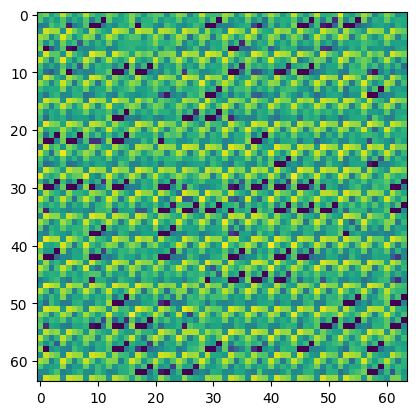

In [ ]:
z = torch.randn(16,latent_dim)
fake = G(z)

print(fake.shape)


fake_img = fake[0].detach().numpy()

fake_img = fake_img.transpose(1,2,0)
plt.imshow(fake_img)